In [1]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
from numpy.linalg import inv as inv
from scipy.stats import invwishart
import time
import matplotlib.pyplot as plt
import seaborn as sns
# from line_profiler import LineProfiler
# %load_ext line_profiler

def Sample_mu_Sigma(X, lambda_0, mu_0, nu_0, Psi_0):
    N, L = X.shape
    X_bar = np.mean(X, axis = 0)
    lambda_hyper = N + lambda_0
    mu_hyper = (N * X_bar + lambda_0 * mu_0) / lambda_hyper
    bar_d = np.repeat(X_bar.reshape(1, L), repeats = N, axis=0)
    S = (N - 1) * np.cov((X - bar_d).T)
    Psi_hyper = Psi_0 + S + N * lambda_0 / (N + lambda_0) * np.outer(X_bar - mu_0, X_bar - mu_0)
    nu_hyper = N + nu_0
    Sigma = invwishart.rvs(df = nu_hyper, scale = Psi_hyper)
    mu = mvnrnd(mu_hyper, Sigma / lambda_hyper)
    return mu, Sigma

def Corr(cov):
    '''
    Covariance to Correlation
    '''
    p = len(cov)
    e = np.eye(p)
    variance = e * cov
    v = np.power(variance, 0.5)
    I = np.linalg.inv(v)
    corr = I.dot(cov).dot(I)
    return corr

def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    r, l = M.shape
    X0 = np.random.randn(r, l)
    P = np.linalg.cholesky(U+0.00001*np.eye(r))
    Q = np.linalg.cholesky(V+0.00001*np.eye(r))
    return M + P @ X0 @ Q.T

In [3]:
with open('Train.npy', 'rb') as f:
    dat = np.load(f)

In [4]:
obs_seq = (dat - dat.mean(axis = 0)) / dat.std(axis = 0)

In [24]:
K = 4
N, link_num = obs_seq.shape
k_list = list(range(K))

epoach = 5000
flag = 0

mu_K = np.zeros((K, link_num))
mu_store = np.zeros((epoach, K, link_num))
Sigma_K = np.zeros((K, link_num, link_num))
Sigma_store = np.zeros((epoach, K, link_num, link_num))
B_K = np.zeros((K, link_num, link_num))
B_store = np.zeros((epoach, K, link_num, link_num))
A_store = np.zeros((epoach, K, K))

# Initialization
pi = np.ones((K, K))
pi_temp = np.ones((K, K))
pi = pi / np.sum(pi[0])
Nk = np.zeros(K, dtype='int32')
z = np.random.choice(k_list, N, p = pi[0])
A_count = np.zeros((K, K), dtype='int32')
A0_count = np.zeros(K, dtype='int32')
X_temp = np.zeros((N-1, link_num))

# Hyperparameters
alpha_0 = np.array([0.1] * K)
lambda_0 = 0.1
mu_0 = obs_seq.mean(axis = 0)
nu_0 = link_num + 2
Psi_0 = 0.01 * np.eye(link_num)
M_0 = np.zeros((link_num,link_num))
V_0 = 0.01 * np.eye(link_num)
invSigma = np.zeros(Sigma_K.shape)
chol = np.zeros(Sigma_K.shape)
logdet = np.zeros(K)
logpi = np.zeros((K, K))
start = time.time()

for it in range(epoach):
    # Update A
    for k in k_list:
        inv_V_0 = inv(V_0)
        V0 = inv(inv_V_0 + obs_seq[np.where(z == k)[0]-1].T @ obs_seq[np.where(z == k)[0]-1])
        M0 = (M_0 @ inv_V_0 + (obs_seq[np.where(z == k)] - mu_K[k]).T @ obs_seq[np.where(z == k)[0]-1]) @ V0
        B_K[k] = mnrnd(M0, Sigma_K[k], V0)
        B_store[it, k] = B_K[k]
    
    # Update mu and sigma 
    for k in k_list:
        Xk = obs_seq[np.where(z == k)] - obs_seq[np.where(z == k)[0]-1] @ B_K[k].T
        if Xk.shape[0] > 1:
            mu_K[k, :], Sigma_K[k, :, :] = Sample_mu_Sigma(Xk, lambda_0, mu_0, nu_0, Psi_0)
            mu_store[it, k, :], Sigma_store[it, k, :, :] = mu_K[k, :], Sigma_K[k, :, :]
    
    # Update pi and pi0
    for i in range(N-1):
        A_count[z[i],z[i+1]] += 1
    for ik in k_list:
        for ij in k_list:
            Nk[ij] = A_count[ik,ij]
        alpha = alpha_0 + Nk
        pi_temp[ik, :] = np.random.dirichlet(alpha)
    A_store[it, :, :] = pi_temp

    for k in range(K):
        invSigma[k,:,:] = inv(Sigma_K[k, :, :])
        chol[k, :, :] = np.linalg.cholesky(Sigma_K[k,:,:])
        logdet[k] = - np.sum(np.log(np.diag(chol[k, :, :])))
        for ik in range(K):
            logpi[ik, k] = np.log(pi_temp[ik, k])
            
    for i in range(N):
        A0_count[z[i]] += 1
    pi0 = np.array(A0_count) / np.array(A0_count).sum()
    
    # Upda hidden state zi and z0
    W = pi0.cumsum() 
    z[0] = W.searchsorted(np.random.uniform(0, W[-1]))
    
    for i in range(1,N):
        pzN = np.ones(K)
        for k in range(K):
            Apart = (obs_seq[i, :] - B_K[k] @ obs_seq[i-1, :] - mu_K[k, :])
            if i == N - 1:
                pzN[k] = - 0.5 * Apart @ invSigma[k,:,:] @ Apart.T + logdet[k] + logpi[z[i-1], k]
            else:
                pzN[k] = - 0.5 * Apart @ invSigma[k,:,:] @ Apart.T + logdet[k] + logpi[z[i-1], k] + logpi[k, z[i+1]]
        pz = np.exp(pzN - np.max(pzN))
        pz = pz/np.sum(pz)
        W = pz.cumsum() 
        z[i] = W.searchsorted(np.random.uniform(0, W[-1]))

end = time.time()
print('Running time: %d seconds' % (end - start))

Running time: 367 seconds


In [8]:
mu_est = np.around(mu_store[-100:, :].mean(axis = 0),2)
cov_est = Sigma_store[-100:, :].mean(axis = 0)
A_est = A_store[-100:, :].mean(axis = 0)
B_est = B_store[-100:, :].mean(axis = 0)

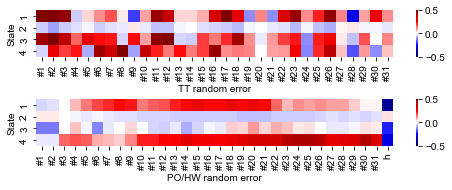

In [10]:
# plt.subplots_adjust(hspace=0.3, wspace=0.3)
link_num = 31
ulink_num = link_num
f,(ax1,ax2) = plt.subplots(2,1,figsize=(8, 2.5))
plt.subplots_adjust(hspace=0.9, wspace=0.05)
plt.rc('font',family='Arial',size=8)
# ax1 = plt.subplot(3,1,1)
x_tick=['#' + str(i) for i in range(1,link_num+1)]
y_tick = [str(i+1) for i in range(K)]
g1 = sns.heatmap(np.around(mu_est[:,:ulink_num],2),annot=False,
                 annot_kws={'size':10, 'color':'black'},cmap = 'seismic', vmin = -0.5, vmax = 0.5, ax=ax1,xticklabels=x_tick, yticklabels=y_tick,fmt='g')
g1.set_ylabel('State')
g1.set_xlabel('TT random error')

x_tick=['#' + str(i) for i in range(1,link_num+1)] + ['h']
g4 = sns.heatmap(np.around(mu_est[:,ulink_num:ulink_num*2+1],2),annot=False,
                 annot_kws={'size':10, 'color':'black'},cmap = 'seismic',vmin = -0.5, vmax = 0.5,ax=ax2,xticklabels=x_tick,yticklabels=y_tick,fmt='g')
g4.set_ylabel('State')
g4.set_xlabel('PO/HW random error')
plt.savefig(r"D:\MSAR\Mean_vector.pdf", bbox_inches='tight')

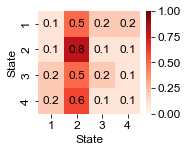

In [21]:
y_tick = [i for i in range(1,5)]
plt.rc('font',family='Arial',size = 12)
fig, ax = plt.subplots(1, 1, figsize = (2.5, 2), constrained_layout=True)
sns.heatmap(np.around(A_est,2),linewidths = 0.00005,annot=True, 
        annot_kws={'size':12, 'color':'black'},cmap="Reds",xticklabels = y_tick, yticklabels = y_tick, fmt='g',vmin=0, vmax = 1, cbar = True)
ax.set_xlabel('State')
ax.set_ylabel('State')
plt.savefig(r"D:\MSAR\Transition.pdf", bbox_inches='tight')

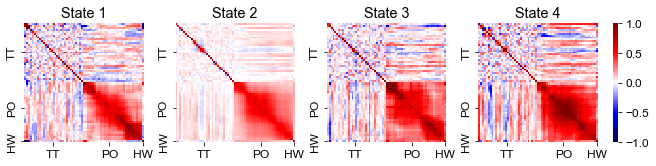

In [22]:
plt.rc('font',family='Arial',size = 12)
fig, ax = plt.subplots(1,4, figsize = (9, 2.2), constrained_layout=True,gridspec_kw={'width_ratios': [1, 1.,1,1]})

sns.heatmap(np.around(cov_est[0], 2), ax = ax[0], cmap = 'seismic', vmin = -1, vmax = 1, cbar = False)
xtick = [15,45,62.5]
xlabel = ['TT','PO','HW'] 
ax[0].set_xticks(xtick)
ax[0].set_xticklabels(xlabel, rotation=0) 
ax[0].set_yticks(xtick)
ax[0].set_yticklabels(xlabel, rotation=90)
ax[0].set_title('State 1')

sns.heatmap(np.around(cov_est[1], 2), ax = ax[1], cmap = 'seismic',  vmin = -1, vmax = 1, cbar = False)
xtick = [15,45,62.5]
xlabel = ['TT','PO','HW'] 
ax[1].set_xticks(xtick)
ax[1].set_xticklabels(xlabel, rotation=0) 
ax[1].set_yticks(xtick)
ax[1].set_yticklabels(xlabel, rotation=90)
ax[1].set_title('State 2')

sns.heatmap(np.around(cov_est[2], 2), ax = ax[2], cmap = 'seismic', vmin = -1, vmax = 1, cbar = False)
xtick = [15,45,62.5]
xlabel = ['TT','PO','HW'] 
ax[2].set_xticks(xtick)
ax[2].set_xticklabels(xlabel, rotation=0) 
ax[2].set_yticks(xtick)
ax[2].set_yticklabels(xlabel, rotation=90)
ax[2].set_title('State 3')

sns.heatmap(np.around(cov_est[3], 2), ax = ax[3], cmap = 'seismic', vmin = -1, vmax = 1, cbar = True)
xtick = [15,45,62.5]
xlabel = ['TT','PO','HW']  
ax[3].set_xticks(xtick)
ax[3].set_xticklabels(xlabel, rotation=0) 
ax[3].set_yticks(xtick)
ax[3].set_yticklabels(xlabel, rotation=90)
ax[3].set_title('State 4')

plt.savefig(r"D:\MSAR\Cov.pdf", bbox_inches='tight')

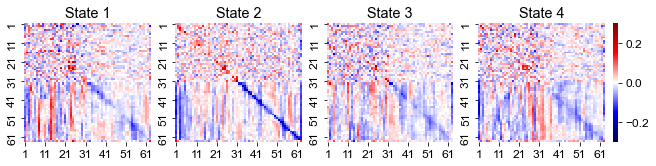

In [23]:
plt.rc('font',family='Arial',size = 12)
fig, ax = plt.subplots(1,4, figsize = (9, 2.2), constrained_layout=True,gridspec_kw={'width_ratios': [1, 1.,1,1]})

sns.heatmap(np.around(B_est[0], 2), ax = ax[0], cmap = 'seismic', vmin = -0.3, vmax = 0.3, cbar = False)
xtick = [i+0.5 for i in range(0,63,10)]
xlabel = [i for i in range(1,64,10)]
ax[0].set_xticks(xtick)
ax[0].set_xticklabels(xlabel, rotation=0) 
ax[0].set_yticks(xtick)
ax[0].set_yticklabels(xlabel, rotation=90)
ax[0].set_title('State 1')

sns.heatmap(np.around(B_est[1], 2), ax = ax[1], cmap = 'seismic',  vmin = -0.3, vmax = 0.3, cbar = False)
xtick = [i+0.5 for i in range(0,63,10)]
xlabel = [i for i in range(1,64,10)] 
ax[1].set_xticks(xtick)
ax[1].set_xticklabels(xlabel, rotation=0) 
ax[1].set_yticks(xtick)
ax[1].set_yticklabels(xlabel, rotation=90)
ax[1].set_title('State 2')

sns.heatmap(np.around(B_est[2], 2), ax = ax[2], cmap = 'seismic', vmin = -0.3, vmax = 0.3, cbar = False)
xtick = [i+0.5 for i in range(0,63,10)]
xlabel = [i for i in range(1,64,10)] 
ax[2].set_xticks(xtick)
ax[2].set_xticklabels(xlabel, rotation=0) 
ax[2].set_yticks(xtick)
ax[2].set_yticklabels(xlabel, rotation=90)
ax[2].set_title('State 3')

sns.heatmap(np.around(B_est[3], 2), ax = ax[3], cmap = 'seismic', vmin = -0.3, vmax = 0.3, cbar = True)
xtick = [i+0.5 for i in range(0,63,10)]
xlabel = [i for i in range(1,64,10)]  
ax[3].set_xticks(xtick)
ax[3].set_xticklabels(xlabel, rotation=0) 
ax[3].set_yticks(xtick)
ax[3].set_yticklabels(xlabel, rotation=90)
ax[3].set_title('State 4')

plt.savefig(r"D:\MSAR\Coefficient.pdf", bbox_inches='tight')